The data come from:
http://insideairbnb.com/get-the-data.html

The medium post:
https://medium.com/@lucas.pontesm/how-much-one-can-make-with-airbnb-in-bristol-uk-an-exploratory-analysis-52e38ea7fc0b

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
%matplotlib inline

In [2]:
reviews = pd.read_csv('reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,70820,8163487,2013-10-18,7538116,Neralee,We loved our stay with Sarah in Bristol. She w...
1,70820,8397676,2013-10-28,9601180,Terry,Sarah gave us and Laddie our dog a very warm w...
2,70820,8706695,2013-11-12,9697980,Alice,Exactly as described on the site and praised b...
3,70820,13024371,2014-05-17,2388955,Thomas,"Sarah was great. She was warm and welcoming, e..."
4,70820,14247963,2014-06-15,16317003,Dimitrije,The experience was really great at Sarah's hou...


In [5]:
listing = pd.read_csv('listings.csv')
print(listing.shape)
listing.head()

(2638, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,70820,https://www.airbnb.com/rooms/70820,20190714024620,2019-07-14,City View - Sarah's double room.,A good sized room with a comfy double bed and ...,The room is in an old Victorian house and has ...,A good sized room with a comfy double bed and ...,none,The neighbourhood is friendly and welcoming; m...,...,f,f,strict_14_with_grace_period,t,f,5,0,5,0,2.02
1,117122,https://www.airbnb.com/rooms/117122,20190714024620,2019-07-14,City Centre-Waterside Retreat,My Harbourside apartment centrally located min...,"A quiet, serene apartment in Bristol city cent...",My Harbourside apartment centrally located min...,none,This area is on the water and has splendid vie...,...,f,f,flexible,f,f,1,0,1,0,1.35
2,146407,https://www.airbnb.com/rooms/146407,20190714024620,2019-07-14,Sunny Central Artist Cottage (Dbl),Large comfortable double room in an artist's h...,• The Large Double room can accommodate 2-4 pe...,Large comfortable double room in an artist's h...,none,• Southville is pretty darn hipster these days...,...,f,f,moderate,f,f,2,0,2,0,0.81
3,176306,https://www.airbnb.com/rooms/176306,20190714024620,2019-07-14,The White Room - Central Bristol Art House Ga...,"A small double room in an artist's house, with...",Private room in a characterful cottage / artis...,"A small double room in an artist's house, with...",none,"Southville is pretty darn hip, frankly. North ...",...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.43
4,220956,https://www.airbnb.com/rooms/220956,20190714024620,2019-07-14,"Light, Modern, 1st Floor Apartment.",My light modern apartment is handily located j...,Please come and stay at my apartment close to ...,My light modern apartment is handily located j...,none,Bedminster is often described as 'up & coming'...,...,f,f,moderate,f,f,1,1,0,0,0.90


In [3]:
reviews['month'] = reviews['date'].apply(lambda d: pd.to_datetime(d).month)

In [6]:
rev_mon = ((reviews.groupby(['listing_id', 'month']).count().reset_index()[['listing_id', 'month', 'comments']]).
           join(listing)[['month','comments',  'latitude', 'longitude']])
rev_mon.head()

,month,comments,latitude,longitude
0,1,7,51.43994,-2.59173
1,2,12,51.45051,-2.61054
2,3,6,51.44131,-2.60271
3,4,13,51.44101,-2.60121
4,5,16,51.43852,-2.60142


Text(0.5, 0, '')

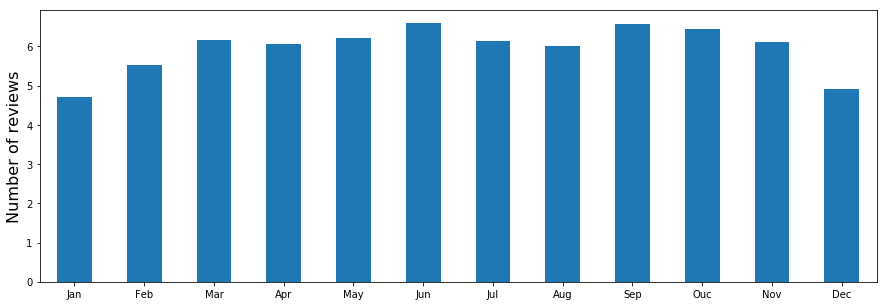

In [8]:
mes = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Ouc", "Nov", "Dec"]
ax = rev_mon.groupby('month').mean().comments.plot(x = mes, kind = 'bar', figsize = [15,5])
for m in ax.set_xticklabels(mes):
    m.set_rotation(0)

ax.set_ylabel("Number of reviews", fontsize = 16)
ax.set_xlabel(None)


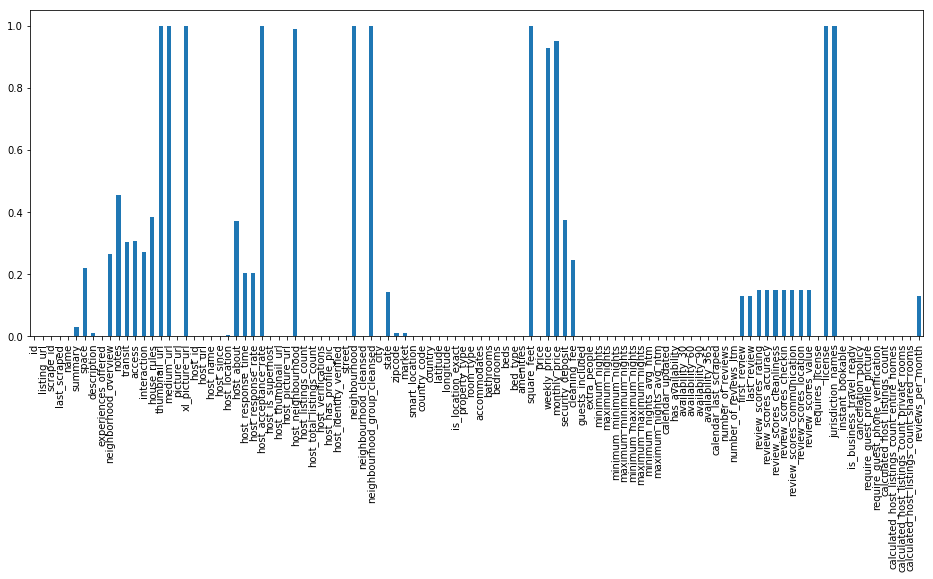

In [64]:
#verify the amount of missing data
listing.isna().mean().plot(kind='bar', figsize = [16,6])

In [65]:
listing.loc[:,listing.isna().mean() <.6].isna().mean().sort_values(ascending = False)

notes                                           0.453753
house_rules                                     0.382866
security_deposit                                0.375284
host_about                                      0.371114
access                                          0.307051
transit                                         0.304018
interaction                                     0.270660
neighborhood_overview                           0.264973
cleaning_fee                                    0.247536
space                                           0.219484
host_response_time                              0.204321
host_response_rate                              0.204321
review_scores_value                             0.149735
review_scores_location                          0.149735
review_scores_checkin                           0.149735
review_scores_communication                     0.148976
review_scores_cleanliness                       0.148976
review_scores_accuracy         

In [27]:
#remove columns with more than 60% of missing data
listing_removed = listing.loc[:,listing.isna().mean() <.6]
listing_removed.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,70820,https://www.airbnb.com/rooms/70820,20190714024620,2019-07-14,City View - Sarah's double room.,A good sized room with a comfy double bed and ...,The room is in an old Victorian house and has ...,A good sized room with a comfy double bed and ...,none,The neighbourhood is friendly and welcoming; m...,...,f,f,strict_14_with_grace_period,t,f,5,0,5,0,2.02
1,117122,https://www.airbnb.com/rooms/117122,20190714024620,2019-07-14,City Centre-Waterside Retreat,My Harbourside apartment centrally located min...,"A quiet, serene apartment in Bristol city cent...",My Harbourside apartment centrally located min...,none,This area is on the water and has splendid vie...,...,f,f,flexible,f,f,1,0,1,0,1.35
2,146407,https://www.airbnb.com/rooms/146407,20190714024620,2019-07-14,Sunny Central Artist Cottage (Dbl),Large comfortable double room in an artist's h...,• The Large Double room can accommodate 2-4 pe...,Large comfortable double room in an artist's h...,none,• Southville is pretty darn hipster these days...,...,f,f,moderate,f,f,2,0,2,0,0.81
3,176306,https://www.airbnb.com/rooms/176306,20190714024620,2019-07-14,The White Room - Central Bristol Art House Ga...,"A small double room in an artist's house, with...",Private room in a characterful cottage / artis...,"A small double room in an artist's house, with...",none,"Southville is pretty darn hip, frankly. North ...",...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,0.43
4,220956,https://www.airbnb.com/rooms/220956,20190714024620,2019-07-14,"Light, Modern, 1st Floor Apartment.",My light modern apartment is handily located j...,Please come and stay at my apartment close to ...,My light modern apartment is handily located j...,none,Bedminster is often described as 'up & coming'...,...,f,f,moderate,f,f,1,1,0,0,0.90


### 1) Estimate income per month

In [21]:
#using a function to parse numerical data
def convert(p):
        try:
            return float(p.strip("$").replace(",",""))
        except:
            try:
                return float(p.strip("%"))
            except:
                return np.nan

In [28]:
listing_removed.loc[:,'price'] = listing_removed['price'].apply(convert)

In [29]:
listing_removed.loc[:,'cleaning_fee'] = listing_removed['cleaning_fee'].apply(convert)

In [30]:
listing_removed.loc[:,'security_deposit'] = listing_removed['security_deposit'].apply(convert)

In [31]:
listing_removed.loc[:,'extra_people'] = listing_removed['extra_people'].apply(convert)

In [32]:
listing_removed['host_is_superhost'].replace(['f','t'],[0,1],inplace=True)

In [33]:
listing_removed.loc[:,'month_earn'] = (listing_removed['price'] * 
                                       listing_removed['minimum_nights'] * 
                                       listing_removed['reviews_per_month'])

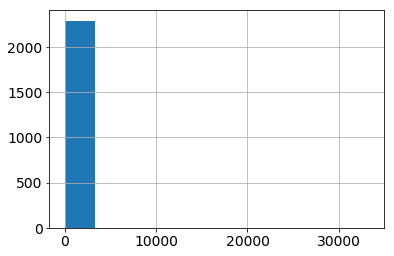

In [34]:
listing_removed['month_earn'].hist()

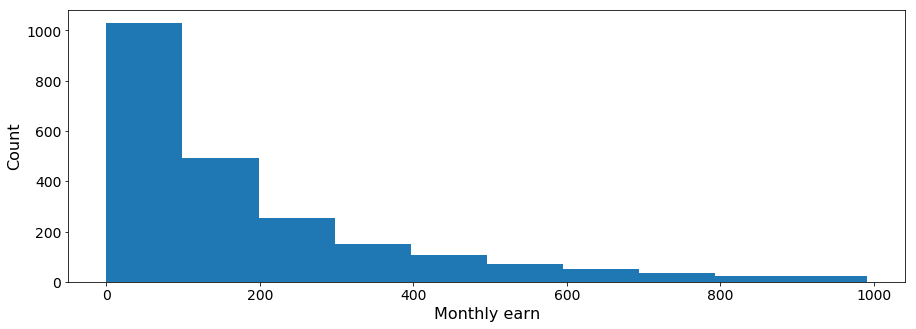

In [35]:
less_than = listing_removed[listing_removed['month_earn'] <= 1000].month_earn
ax = less_than.hist(grid = False, figsize = [15,5])
ax.set_ylabel('Count', size = 16)
ax.set_xlabel('Monthly earn',size = 16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

In [36]:
listing_removed['price'].max()

1600.0

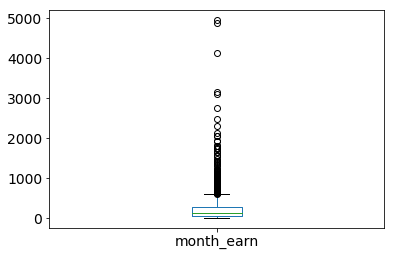

In [54]:
#boxplot of income per month less than £10,000.00

listing_removed[listing_removed['month_earn'] <= 10000]['month_earn'].sort_values(ascending = False).plot(kind = 'box')

## 2) What is the spatial distribution of the income?

In [61]:
listing_removed.groupby('neighbourhood_cleansed').mean().price

neighbourhood_cleansed
Ashley                          81.993921
Avonmouth & Lawrence Weston     59.953846
Bedminster                      59.237288
Bishopston & Ashley Down        66.095238
Bishopsworth                    41.809524
Brislington East               117.173913
Brislington West                56.414634
Central                        108.313208
Clifton                         89.295699
Clifton Down                    87.525316
Cotham                          78.875000
Easton                          55.134921
Eastville                       60.930556
Filwood                         45.250000
Frome Vale                      59.080000
Hartcliffe & Withywood          38.200000
Henbury & Brentry               69.571429
Hengrove & Whitchurch Park      41.714286
Hillfields                      53.344828
Horfield                        62.170732
Hotwells & Harbourside          92.703297
Knowle                          54.771429
Lawrence Hill                   61.503106
Lockleaze  

Text(0, 0.5, 'Neighbourhood')

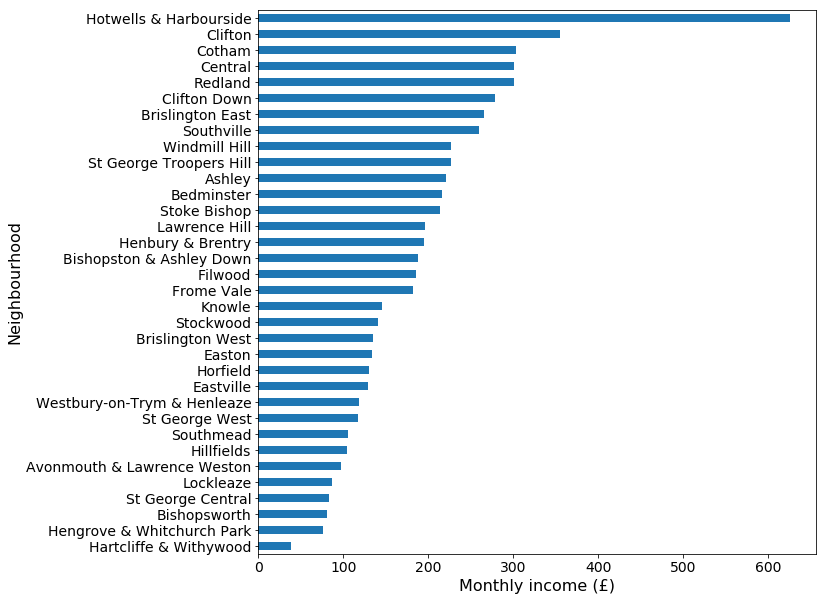

In [55]:
sorted_income = listing_removed.groupby('neighbourhood_cleansed').mean().sort_values('month_earn').month_earn
ax = sorted_income.plot.barh(figsize = [10,10])
ax.set_xlabel("Monthly income (\xA3)", fontsize = 16)
ax.set_ylabel("Neighbourhood", fontsize = 16)

In [53]:
listing_removed.groupby('neighbourhood_cleansed').mean().reviews_per_month

neighbourhood_cleansed
Ashley                         1.878581
Avonmouth & Lawrence Weston    1.574643
Bedminster                     1.957091
Bishopston & Ashley Down       1.872174
Bishopsworth                   1.777222
Brislington East               1.322857
Brislington West               1.807568
Central                        2.632523
Clifton                        2.525749
Clifton Down                   2.180977
Cotham                         2.274615
Easton                         1.589817
Eastville                      1.574921
Filwood                        3.690625
Frome Vale                     3.033333
Hartcliffe & Withywood         1.088000
Henbury & Brentry              1.431818
Hengrove & Whitchurch Park     1.211429
Hillfields                     1.319615
Horfield                       1.846364
Hotwells & Harbourside         2.028554
Knowle                         1.901667
Lawrence Hill                  2.098112
Lockleaze                      1.679714
Redland          

In [56]:
Map = folium.Map(location = [51.44, -2.58], zoom_start = 12)
droped = listing_removed.dropna(subset=['latitude', 'longitude', 'month_earn'])
HeatMap(data=droped[['latitude', 'longitude', 'month_earn']].groupby(['latitude', 'longitude']).mean().reset_index().values.tolist(), radius=8, max_zoom=13,min_opacity = .1 ).add_to(Map)
Map

### 3) What features are related to income per month (feature selection)

In [260]:
listing_removed.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximu

In [57]:
#function used to clean and process the data
#create dummy variables to te categorical features
#normalize and scale the data in order to be used on modeling

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    def convert(p):
        try:
            return float(p.strip("$").replace(",",""))
        except:
            try:
                return int(p.strip("%"))
            except:
                return np.nan
    listing_removed = df.loc[:,df.isna().mean() <.6]
    listing_removed.loc[:,'price'] = listing_removed['price'].apply(convert)
    listing_removed.loc[:,'cleaning_fee'] = listing_removed['cleaning_fee'].apply(convert)
    listing_removed.loc[:,'security_deposit'] = listing_removed['security_deposit'].apply(convert)
    listing_removed.loc[:,'extra_people'] = listing_removed['extra_people'].apply(convert)
    listing_removed['host_is_superhost'].replace(['f','t'],[0,1],inplace=True)
    listing_removed.loc[:,'month_earn'] = listing_removed['price'] * listing_removed['minimum_nights'] * listing_removed['reviews_per_month']
    
    listing_removed.loc[:,'amenities'] = listing_removed['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))
    amenities = np.unique(np.concatenate(listing_removed['amenities'].map(lambda amns: amns.split("|"))))[1:]
    amenity_arr = np.array([listing_removed['amenities'].map(lambda amns: amn in amns) for amn in amenities])
    
    var_num = ['bathrooms', 'bedrooms', 'beds','extra_people', 'cleaning_fee','minimum_nights',
               'maximum_nights', 'review_scores_rating', 'review_scores_accuracy',
               'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
               'review_scores_location', 'review_scores_value','security_deposit']
    
    var_cat = ['neighbourhood_cleansed','property_type','room_type','accommodates','bed_type', 
            'guests_included','cancellation_policy']
    
    #fill na with mean values for numeric columns
    num_feat_fill = listing_removed[var_num].fillna(listing_removed[var_num].mean())
    
    #normalize
    num_log_transformed = num_feat_fill.apply(lambda x: np.log(x + 1))
       
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() 
    num_log_minmax_transform = scaler.fit_transform(num_log_transformed)
    
    features = pd.concat([listing_removed['month_earn'],
                          listing_removed['host_is_superhost'],
                          pd.DataFrame(num_log_minmax_transform, columns=var_num),
                          pd.get_dummies(listing_removed[var_cat]),
                          pd.DataFrame(data=amenity_arr.T, columns=amenities)],
                         axis=1)
    
    features.dropna(inplace=True)
    
    y = features.month_earn
    X = features.drop(columns = ["month_earn"])
    
    
    return X, y
    
#Use the function to create X and y
X, y = clean_data(listing)    
X.drop(columns = ['translation missing: en.hosting_amenity_50','translation missing: en.hosting_amenity_49' ], inplace=True)
#remover colunas sem dados relevantes
X.drop(columns = ['property_type_Boutique hotel','property_type_Earth house','property_type_Castle','property_type_Aparthotel',
                  'cancellation_policy_super_strict_60'], inplace = True)

C:\Users\lucas\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\lucas\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\lucas\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

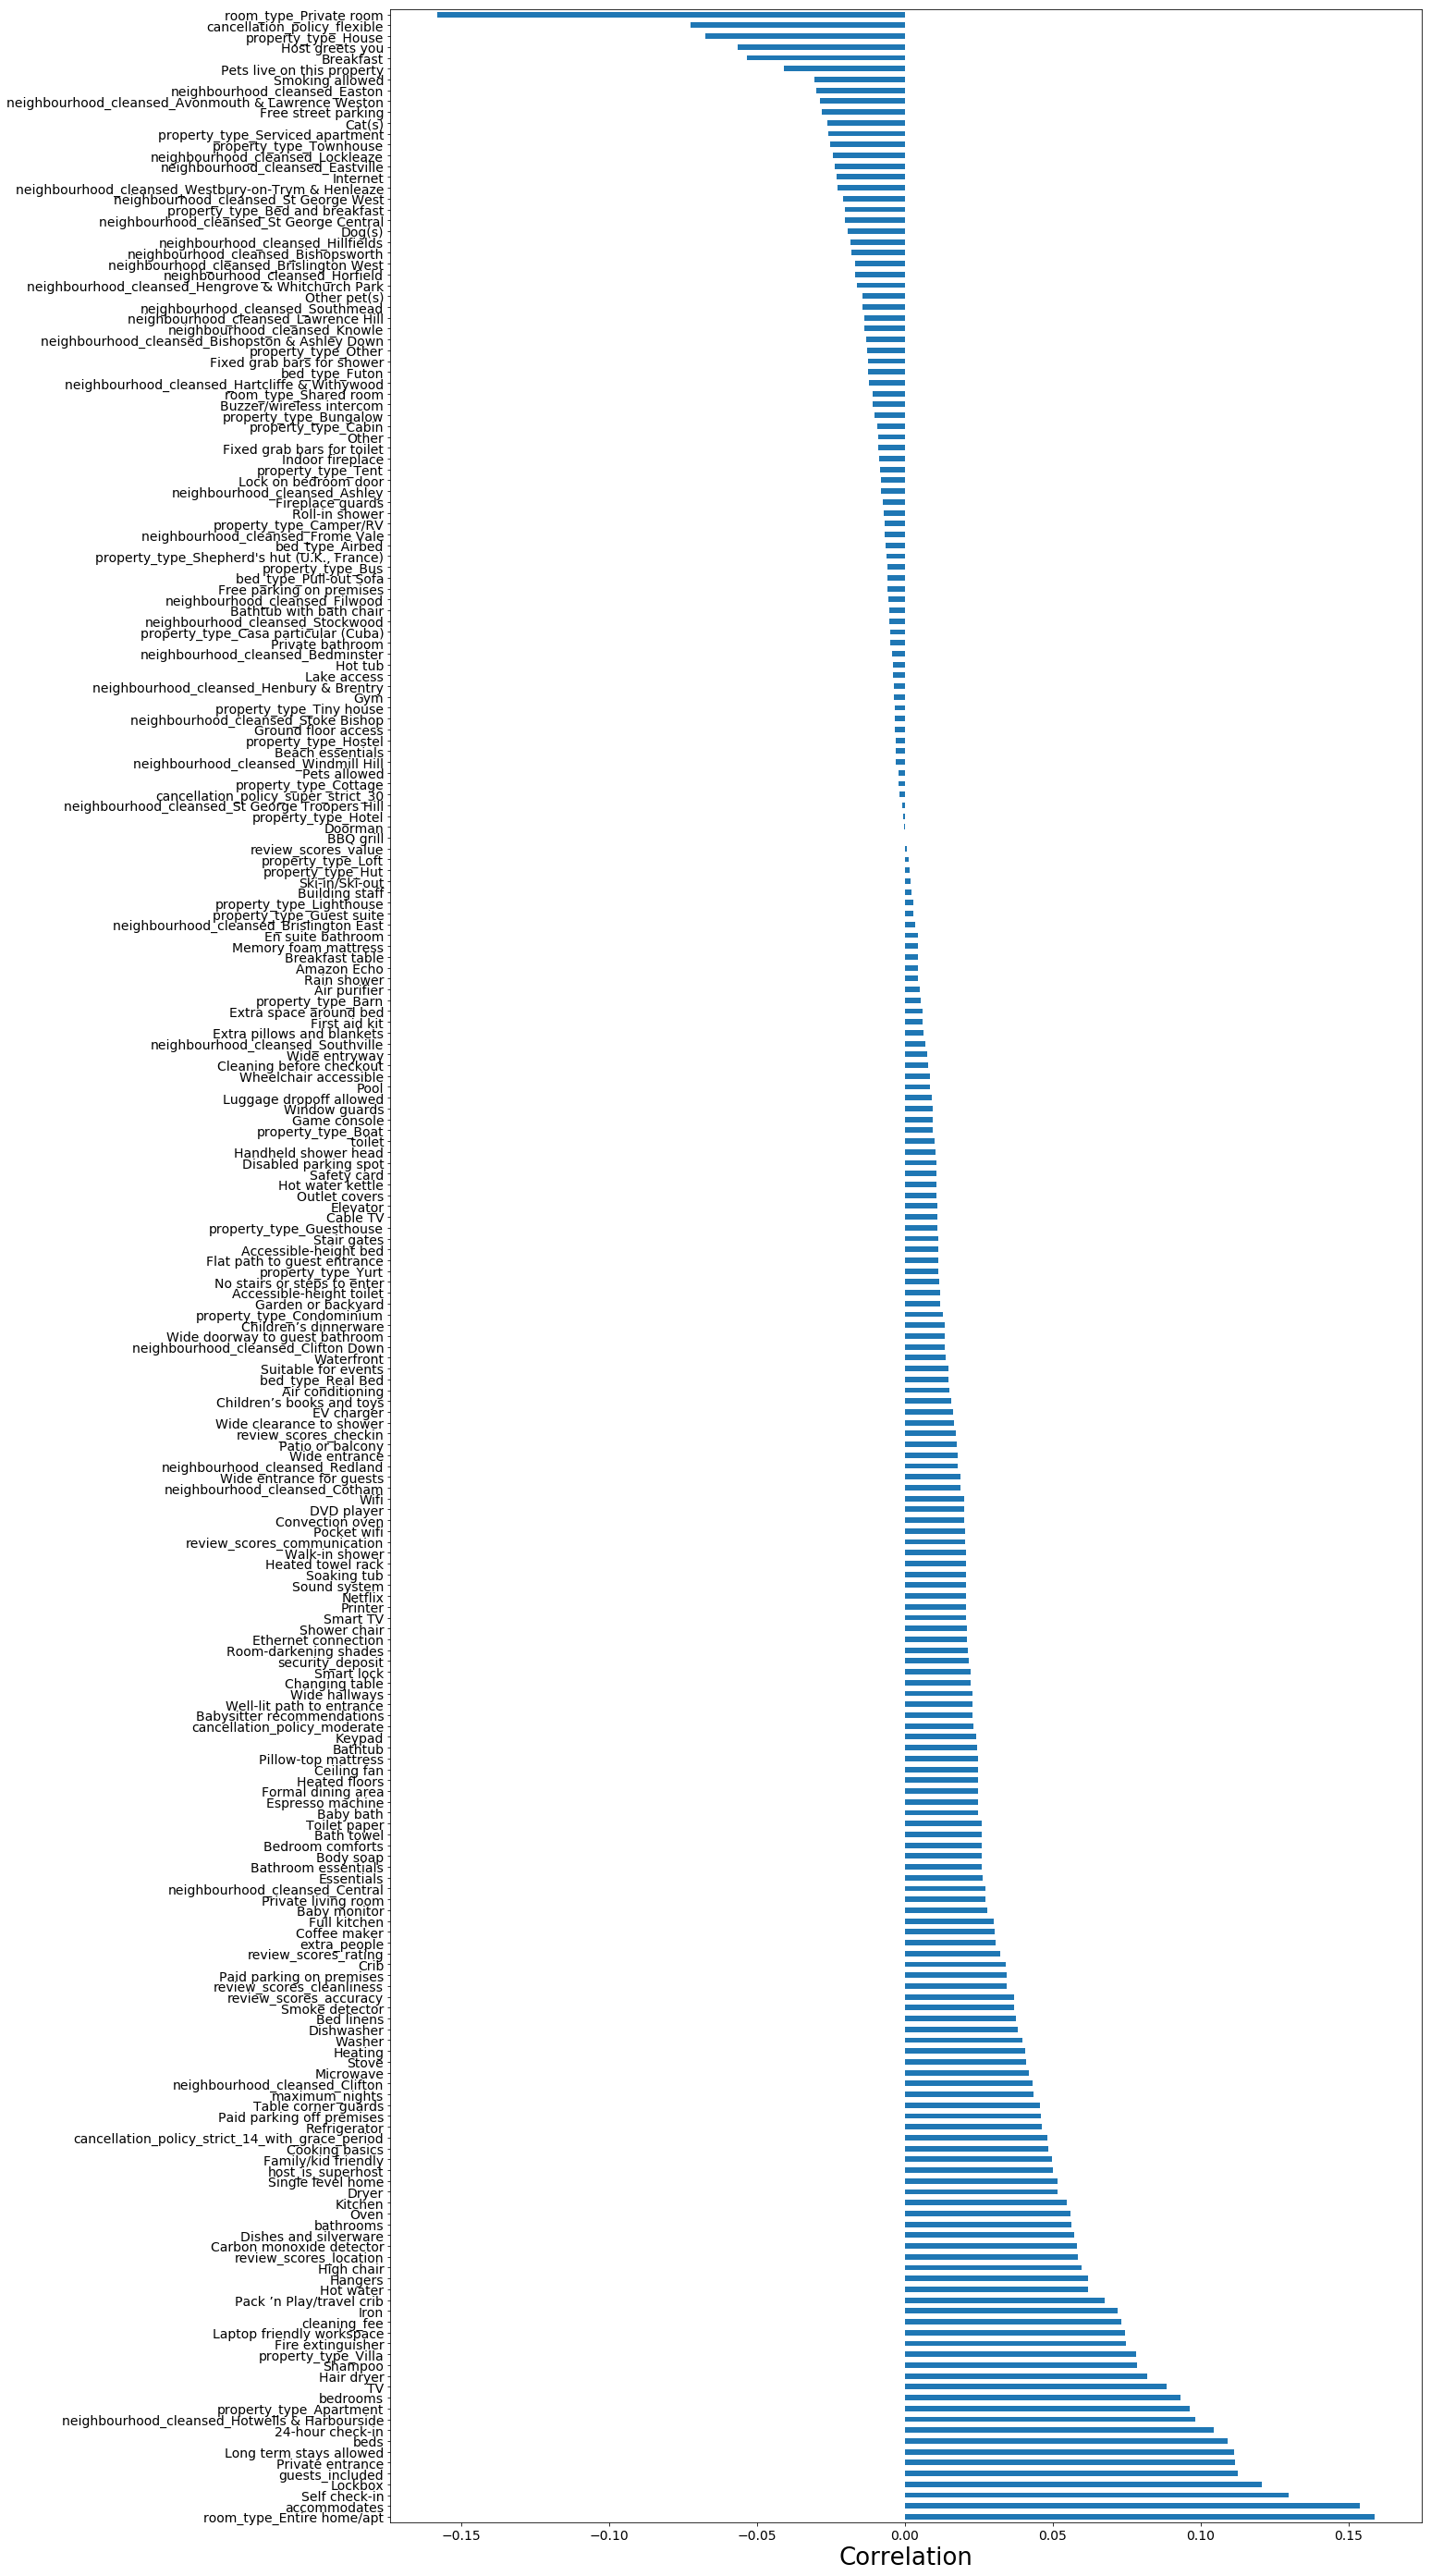

In [59]:
plt.rcParams['figure.figsize'] = (20, 50)
correlat = (pd.concat([X,y], axis = 1).corr()['month_earn'].
            sort_values(ascending = False).drop(['month_earn', 'minimum_nights']))
ax = correlat.plot.barh()
ax.set_xlabel('Correlation', size= 26)
plt.rc('xtick', labelsize=26) 

In [55]:
#sorted correlation values 
(pd.concat([X,y], axis = 1).corr()['month_earn'].
 sort_values(ascending = False).drop(['month_earn', 'minimum_nights']))

room_type_Entire home/apt                             0.158916
accommodates                                          0.153859
Self check-in                                         0.129618
Lockbox                                               0.120712
guests_included                                       0.112538
Private entrance                                      0.111493
Long term stays allowed                               0.111259
beds                                                  0.109097
24-hour check-in                                      0.104372
neighbourhood_cleansed_Hotwells & Harbourside         0.098195
property_type_Apartment                               0.096310
bedrooms                                              0.093160
TV                                                    0.088575
Hair dryer                                            0.081792
Shampoo                                               0.078345
property_type_Villa                                   0

In [28]:
feat_cor = pd.concat([y,X[['Pets live on this property','Breakfast',
                           'Host greets you','property_type_House','cancellation_policy_flexible','room_type_Private room',
                           'room_type_Entire home/apt','accommodates','Self check-in','Lockbox','guests_included',
                           'Private entrance','Long term stays allowed','24-hour check-in','cleaning_fee',
                           'neighbourhood_cleansed_Hotwells & Harbourside','property_type_Apartment','beds','TV',
                           'Hair dryer']]],axis = 1)

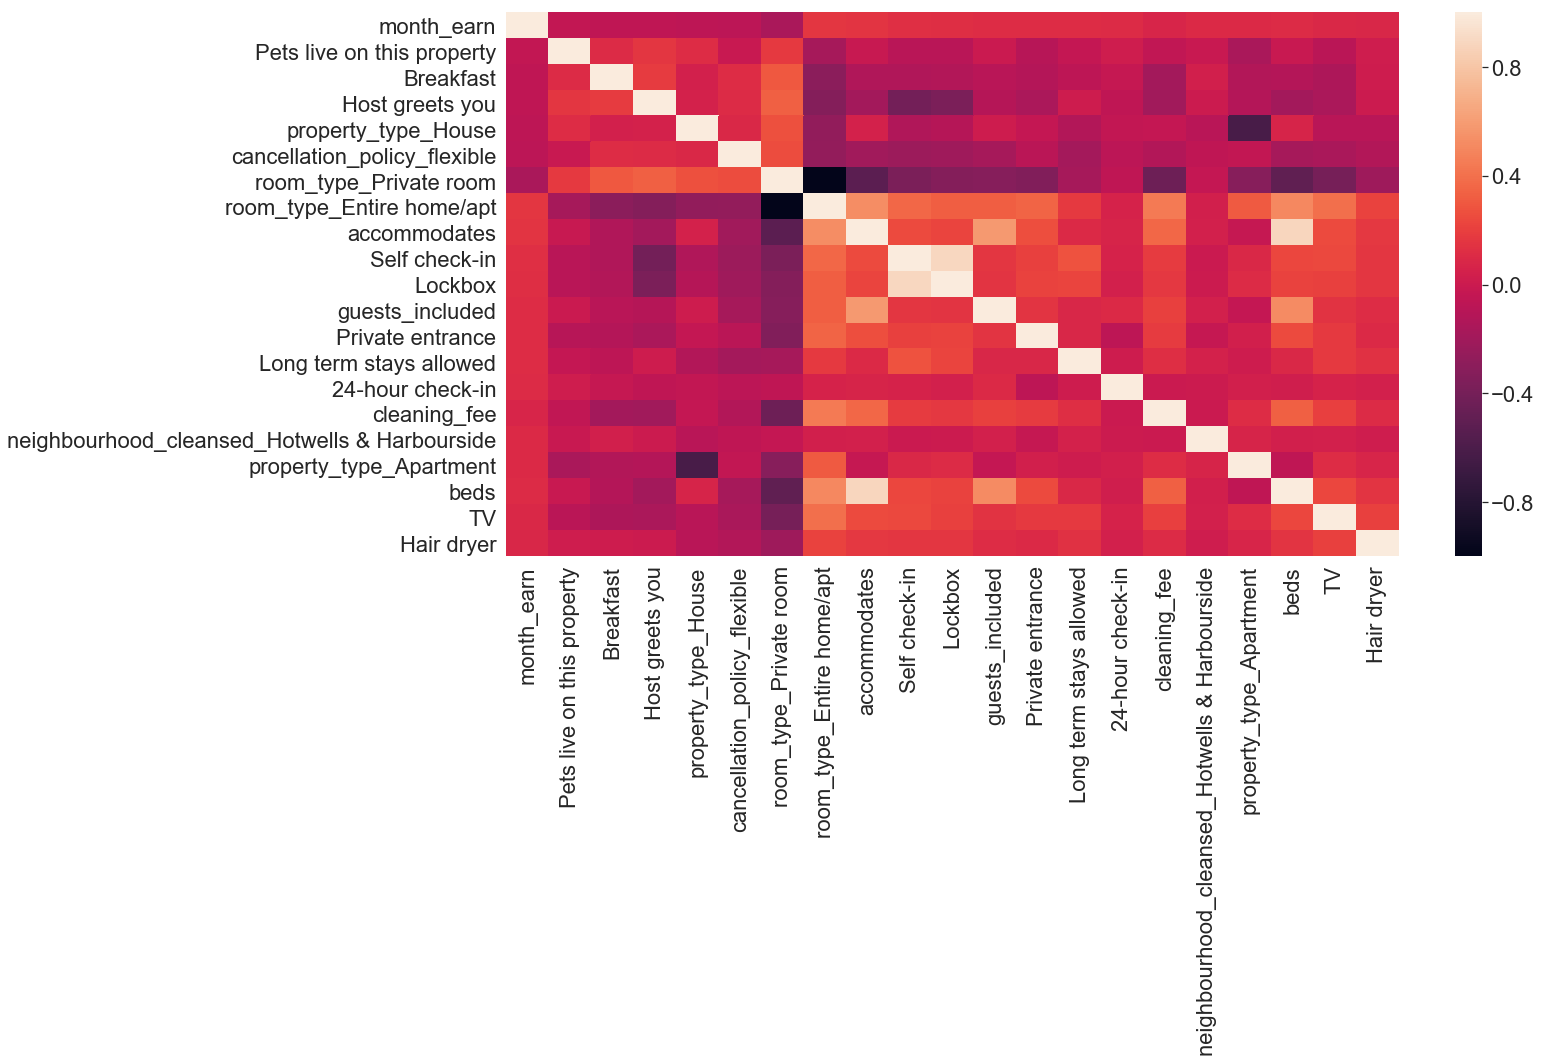

In [41]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(font_scale=2)
sns.heatmap(feat_cor.corr())